# Import Settings 导入所用到的包

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os
import re
import datetime as dt
from matplotlib import pyplot  as plt
import seaborn as sns
sns.set_style("darkgrid",{'font.sans-serif':['simhei','Arial'],'grid.linestyle': '--'})

In [2]:
import warnings
warnings.filterwarnings("ignore")

##### Import self-defined functions 导入自定义函数

In [3]:
from visualization import *
from aggregation import *
from data_handling import *

# Import data from  folder 从文件夹读取数据

In [4]:
# import data from folder named '账单汇总', which is all the transaction data after 08-01
# 从名为“账单汇总” 的文件夹中读取所有表格数据，跳过表头和表尾，合并为一个表格
dir = "账单汇总"

filename_excel = []
frames = []
for root, dirs, files in os.walk(dir):
    for file in files:
        filename_excel.append(os.path.join(root, file))
        df = pd.read_csv(os.path.join(root, file), skiprows=[
                         0, 1, 2, 3], header=0, infer_datetime_format=True, date_parser = True,skipfooter=4, encoding="gbk")
        frames.append(df)
data = pd.concat(frames)

In [4]:
# Aggregated data before August
# 读取八月前的数据并和后面的数据合并，可以省略
past = pd.read_excel('summary.xlsx')
data = pd.concat([past,data])

# Data cleaning and transforming数据清洗和转换格式

In [5]:
# getting only useful fields from data
# 提取重要的列
data_sim = data[['发生时间', '收入金额（+元）',
          '交易渠道', '业务类型', '备注']]
data_sim['发生时间']=pd.to_datetime(data_sim['发生时间'])
data_sim.reset_index(inplace = True, drop = True)

In [6]:
# dealing with the Chinese characters in dataset
# 对中文字符进行正则编码处理
data_sim['备注'] = [i.encode('utf-8') for i in data_sim.备注]
data_sim['备注'] = [get_chinese(i)[0]  for i in data_sim.备注]

## slicing data into different operation type 根据收入类型切割数据

In [7]:
types = ['公交赏金', '地铁赏金', '支付宝推荐奖励','商家权益红包']

data_bus = data_sim[data_sim['备注']==types[0]]
data_metro = data_sim[data_sim['备注']==types[1]]
data_recommend =  data_sim[data_sim['备注']==types[2]]
data_quanyi = data_sim[data_sim['备注']==types[3]]

## Slicing data into old users and new users 根据新老用户切割数据

In [9]:
# through observation, we define new users as those who receiving an income > 1
# 将新用户定义为红包收入大于1元的
data_new = data_bus[data_bus['收入金额（+元）']>1.0]
data_old = data_bus[data_bus['收入金额（+元）']<=1.0]

### Update sum/count for old/new users for everyday 更新每天收入/笔数统计数据表格

In [13]:
# update on the daily income and count for new users and old users
# 更新每天的新老用户收入/笔数
travel = all_travel(data_new,data_old)

# write into a new excel sheet that replace the old one
# 导出为新的Excel表格并替代原先的表格
with pd.ExcelWriter('羊城通红包收入数据.xlsx') as writer:
    travel.to_excel(writer)

### Generate daily plot for analysis 每日收入时变化图

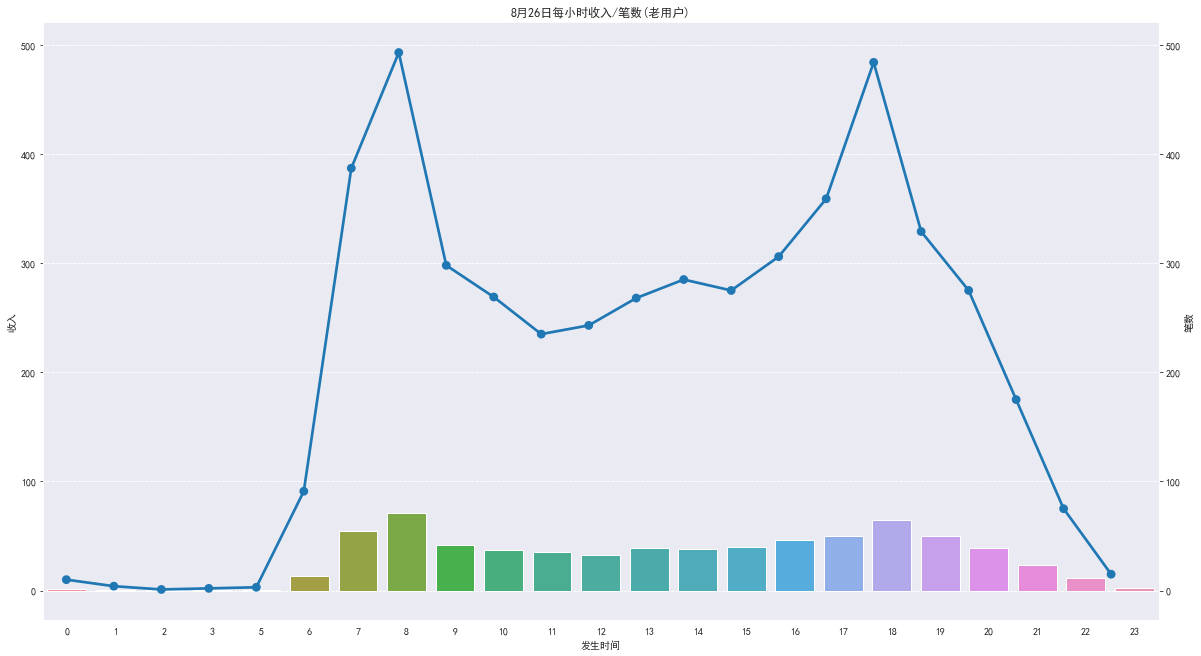

In [13]:
# get the hourly plot for the specific day

# put in the day you want to get in this field
date = dt.date(2020,8,26)  # 输入需要的日期变量
today_data = get_chunk(data_old, date, field = 'date')
agg= get_aggregated(today_data,by = 'hour')
trend_plot(agg, names = ['收入','笔数','8月26日每小时收入/笔数(老用户)'], means=None, reverse = False)

### Generate monthly trend plot 月收入变化趋势

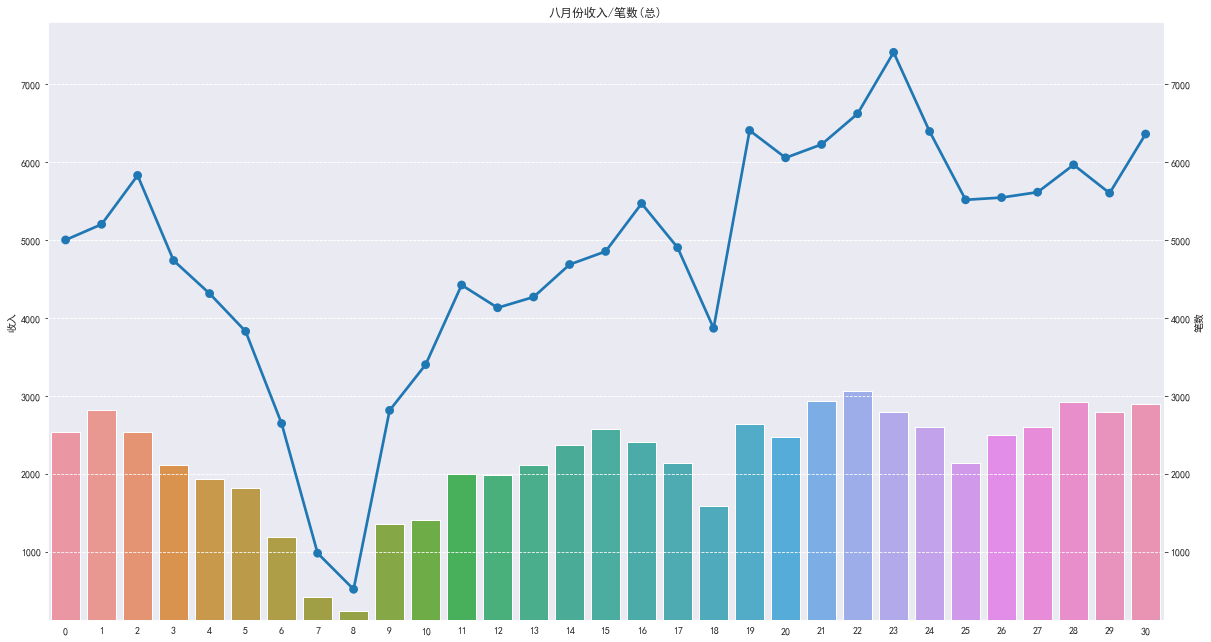

In [16]:
month = 8 #month value， 月份值
monthly_data = get_chunk(data_bus, month, field = 'month')
agg= get_aggregated(monthly_data,by = 'date')


trend_plot(agg, names = ['收入','笔数',str(month)+'月份收入/笔数(总)'], means=None, xtick = agg.index,reverse = False)

## Analyze users travel pattern 分析用户出行模式

### Heatmap for average income per timeframe 收入热力图

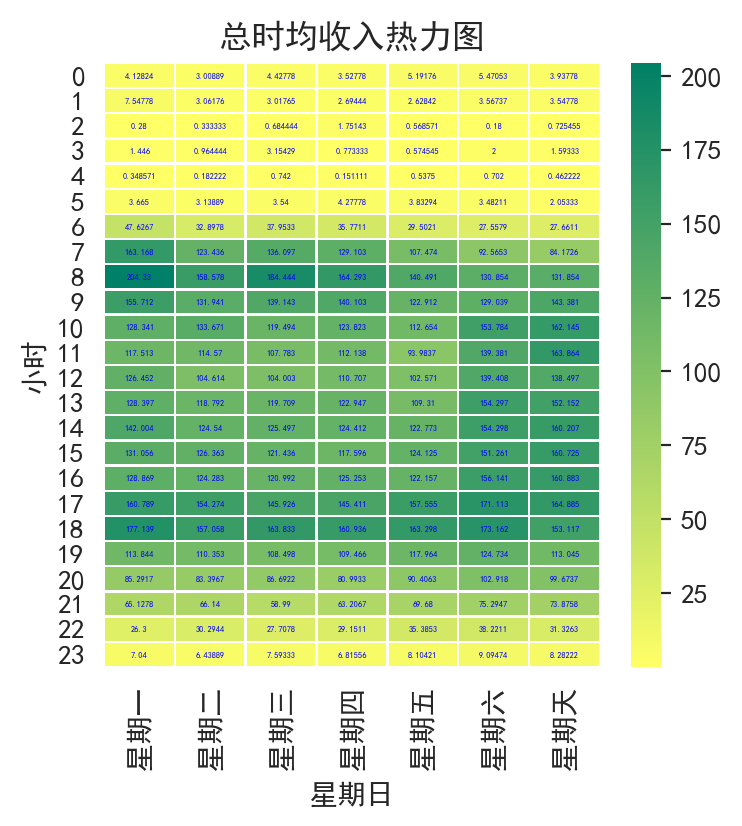

In [17]:
data = data_bus # 所有时间窗口的收入热力图，可通过更改数据集更改时间窗口
heatmap_weekhour(data, '总时均收入热力图',count = False)

### Lineplot for all time(weekdays/weekend) 收入折线图

In [18]:
# Split data on weekday and weekend
# 根据周末和工作日切分数据
data_wd, data_wk = data_bus[data_bus.发生时间.dt.weekday != (6 & 5)], data_bus[(
    data_bus.发生时间.dt.weekday == 6) | (data_bus.发生时间.dt.weekday == 5)]

In [19]:
def lineplot(data, xlabel, ylabel, names=[], xtick=np.arange(0, 24, 1)):
    name, title = names
    plt.rcParams.update({"font.size": 20})
    plt.figure(figsize=(20, 9))
    sns.lineplot(data=data, x=data[xlabel], y=data[ylabel], label=name)
    plt.title(title, fontsize=20)  # for title
    plt.xlabel(xlabel, fontsize=15)  # label for x-axis
    plt.ylabel(ylabel, fontsize=15)  # label for y-axis
    plt.xticks(xtick)
    plt.show()

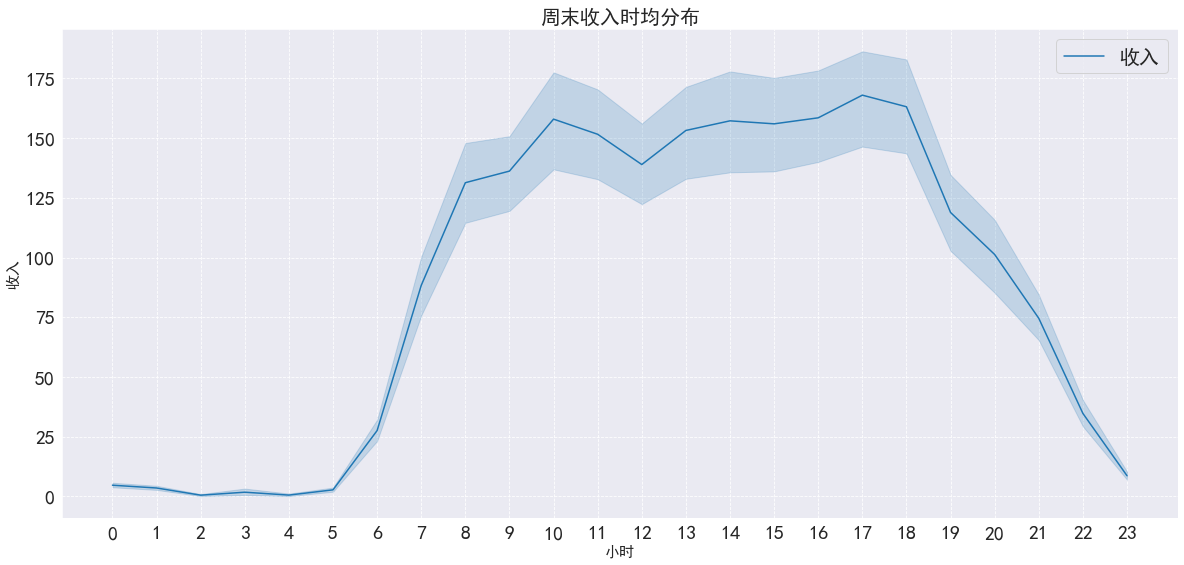

In [20]:
# aggregate data by date and hour, transform the data into the format for lineplotting
# 根据天和小时聚合数据，并转换表格排列便于画图
d = get_aggregated(data_wk, by = 'date_hour')
lineplot(d, '小时','收入',names = ['收入','周末收入时均分布'])

##### Interpretation of the plot 图像解释

The line in the middle is the mean income of the specific hour through the selected timespan, shaded area is the range of actual income.
中间深色折线为所选时间范围的时均收入，阴影区域为真实数据的范围。

# Analyze anomaly 异常天数分析

## Two days comparation 对比两天的收入

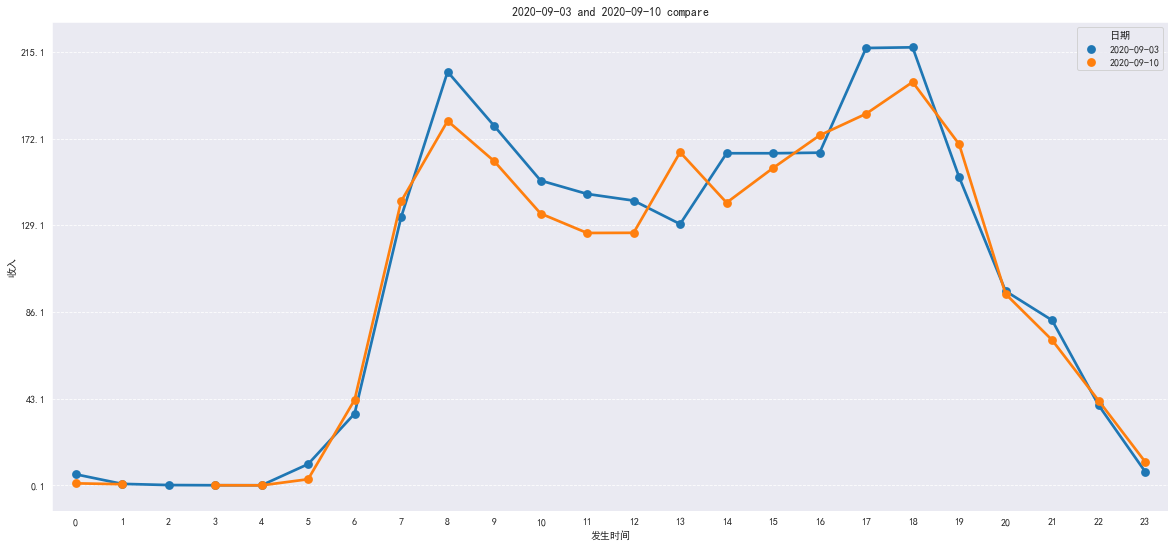

In [24]:
# input two dates for comparing
# 输入需要用作对比的两个日期
date1, date2 = dt.date(2020, 9, 3), dt.date(2020, 9, 10)
anomaly_data, normal_data = get_aggregated(get_chunk(data_bus, date1, field='date'), by='hour'), get_aggregated(
    get_chunk(data_bus, date2, field='date'), by='hour')
anomaly_data['日期'] = date1.strftime('%Y-%m-%d')
normal_data['日期'] = date2.strftime('%Y-%m-%d')
data_all =  pd.concat([anomaly_data,normal_data])
anomaly_plot(data_all,name = str(date1)+' and '+str(date2)+' compare',if_sum=True,xtick = np.arange(0,24,1))

##### Plot interpretation 图像解释

<li>This plot shows the total hourly income for two days, so that we can directly see which hour has the largest difference. It's very helpful in knowing what wents wrong. Also, by changing the input dataset to old users/new users, we can observe which part of user is shrinking.
<li>此折线图代表两天的时总收入对比，可以直观观察某个小时收入的减少/增加。通过更改输入数据集为新用户/老用户数据，可以直观判断收入的减少/增加是由哪部分的用户造成。